## Coincident Index (Dynamic Factor Model)
Based on the statsmodels example: 
https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_dfm_coincident.html

In [1]:
# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from pymc_extras.statespace.core.statespace import PyMCStateSpace
import pytensor.tensor as pt
import pymc as pm

In [2]:
# 2. Download the data
start = datetime.datetime(1979, 1, 1)
end = datetime.datetime(2014, 12, 31)

In [3]:
indprod = DataReader("IPMAN", "fred", start=start, end=end)
income = DataReader("W875RX1", "fred", start=start, end=end)
sales = DataReader("CMRMTSPL", "fred", start=start, end=end)
emp = DataReader("PAYEMS", "fred", start=start, end=end)

In [4]:
data = pd.concat((indprod, income, sales, emp), axis=1)
data.columns = ["indprod", "income", "sales", "emp"]
data.index.freq = data.index.inferred_freq

In [5]:
print(data.head())

            indprod  income       sales    emp
DATE                                          
1979-01-01  47.1722  5248.7  561382.192  88808
1979-02-01  47.3093  5278.5  558729.039  89055
1979-03-01  47.5389  5294.3  574897.892  89479
1979-04-01  46.7402  5242.7  559387.521  89417
1979-05-01  47.3949  5227.5  571771.305  89789


In [6]:
print(data.shape)

(432, 4)


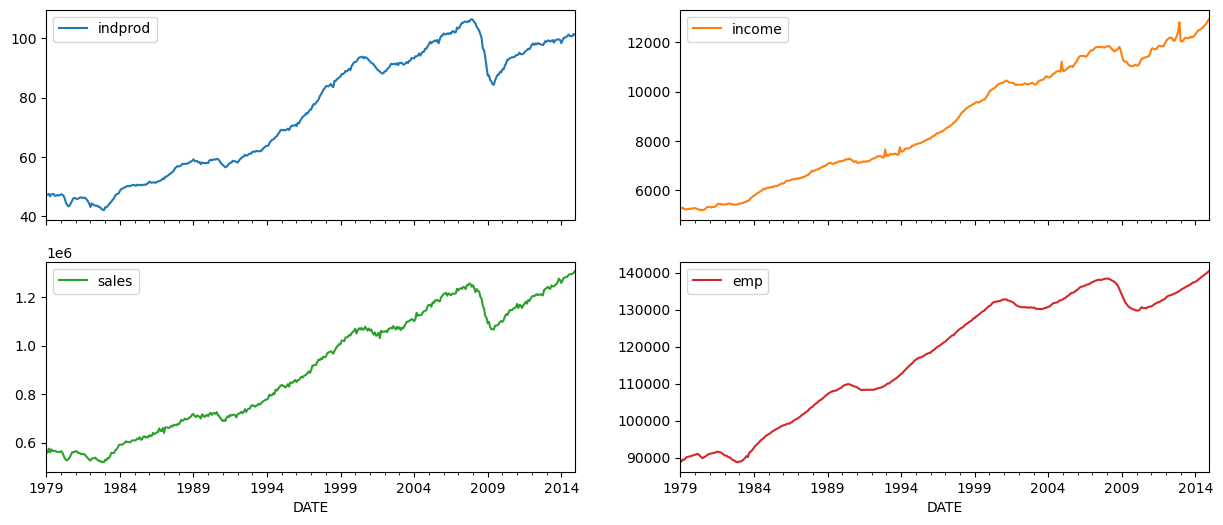

In [7]:
data.loc[:, "indprod":"emp"].plot(subplots=True, layout=(2, 2), figsize=(15, 6));

### Cointegration

In [8]:
def johansen_cointegration_test(df, det_order=-1, k_ar_diff=1):
    """
    Perform Johansen cointegration test
    det_order: Deterministic trend assumption (-1 to 3)
    k_ar_diff: Lag order for differencing (usually 1)
    """
    print("Johansen Cointegration Test Results")
    coint_test = coint_johansen(df.dropna(), det_order, k_ar_diff)

    trace_stat = coint_test.lr1
    crit_values = coint_test.cvt

    for i in range(len(trace_stat)):
        print(f"Rank {i}: Trace Statistic = {trace_stat[i]:.2f}, 90% CV = {crit_values[i, 0]:.2f}, 95% CV = {crit_values[i, 1]:.2f}, 99% CV = {crit_values[i, 2]:.2f}")
        if trace_stat[i] > crit_values[i, 1]:
            print("=> Reject H0: Cointegration rank >=", i)
        else:
            print("=> Fail to reject H0: Cointegration rank <", i)
        print()


In [9]:
coint_data = (data[['indprod', 'income', 'sales', 'emp']])
johansen_cointegration_test(coint_data)

Johansen Cointegration Test Results
Rank 0: Trace Statistic = 85.23, 90% CV = 37.03, 95% CV = 40.17, 99% CV = 46.57
=> Reject H0: Cointegration rank >= 0

Rank 1: Trace Statistic = 27.72, 90% CV = 21.78, 95% CV = 24.28, 99% CV = 29.51
=> Reject H0: Cointegration rank >= 1

Rank 2: Trace Statistic = 6.23, 90% CV = 10.47, 95% CV = 12.32, 99% CV = 16.36
=> Fail to reject H0: Cointegration rank < 2

Rank 3: Trace Statistic = 1.36, 90% CV = 2.98, 95% CV = 4.13, 99% CV = 6.94
=> Fail to reject H0: Cointegration rank < 3



The Johansen test indicates the presence of 2 cointegrating relationships among the 4 time series. This means there are 2 independent stationary linear combinations (cointegrating vectors). However, we will follow our reference, testing stationarity for each time series and eventually applying a tranformation.


### Stationarity

In [10]:
def adf_test(series, title=''):
    """
    Perform Augmented Dickey-Fuller test
    """
    print(f'ADF Test for {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Observations']
    for value, label in zip(result[:4], labels):
        print(f"{label}: {value}")
    if result[1] <= 0.05:
        print("=> Stationary (reject H0)")
    else:
        print("=> Non-stationary (fail to reject H0)")
    print()


In [11]:
for col in ['indprod', 'income', 'sales', 'emp']:
    adf_test(data[col], title=col)
   

ADF Test for indprod
ADF Statistic: -0.6730347475672278
p-value: 0.8536110682655401
# Observations: 12
=> Non-stationary (fail to reject H0)

ADF Test for income
ADF Statistic: 0.0829843235392625
p-value: 0.9648799685690176
# Observations: 9
=> Non-stationary (fail to reject H0)

ADF Test for sales
ADF Statistic: -0.21492222758297064
p-value: 0.936719395568298
# Observations: 12
=> Non-stationary (fail to reject H0)

ADF Test for emp
ADF Statistic: -0.9032661691141197
p-value: 0.7868949183862891
# Observations: 3
=> Non-stationary (fail to reject H0)



In [12]:
# Create log-differenced series
data["dln_indprod"] = (np.log(data.indprod)).diff() * 100
data["dln_income"] = (np.log(data.income)).diff() * 100
data["dln_sales"] = (np.log(data.sales)).diff() * 100
data["dln_emp"] = (np.log(data.emp)).diff() * 100

# De-mean and standardize
data["std_indprod"] = (data["dln_indprod"] - data["dln_indprod"].mean()) / data[
    "dln_indprod"
].std()
data["std_income"] = (data["dln_income"] - data["dln_income"].mean()) / data[
    "dln_income"
].std()
data["std_sales"] = (data["dln_sales"] - data["dln_sales"].mean()) / data["dln_sales"].std()
data["std_emp"] = (data["dln_emp"] - data["dln_emp"].mean()) / data["dln_emp"].std()

In [13]:
# Get the endogenous data
endog = data.loc["1979-02-01":, "std_indprod":"std_emp"]

In [14]:
for col in ["std_indprod","std_income", "std_sales", "std_emp"]:
    adf_test(endog[col], title=col)

ADF Test for std_indprod
ADF Statistic: -7.3337173809532725
p-value: 1.1105668612348205e-10
# Observations: 2
=> Stationary (reject H0)

ADF Test for std_income
ADF Statistic: -4.455094080898953
p-value: 0.0002368322834477289
# Observations: 13
=> Stationary (reject H0)

ADF Test for std_sales
ADF Statistic: -8.827935086435593
p-value: 1.8022396062717108e-14
# Observations: 2
=> Stationary (reject H0)

ADF Test for std_emp
ADF Statistic: -4.175631871435514
p-value: 0.0007243551568346825
# Observations: 2
=> Stationary (reject H0)



As the reference notebook stated reporting the findings of the paper Stock and Watson (1991), we are able to reach stationarity after taking as transformation the first differences (of the logs).

In [15]:
print(endog.head())

            std_indprod  std_income  std_sales   std_emp
DATE                                                    
1979-02-01     0.144369    0.536870  -0.722874  0.897660
1979-03-01     0.392176    0.134841   2.867766  1.929842
1979-04-01    -2.391601   -1.787951  -3.163686 -0.918544
1979-05-01     1.550990   -0.751468   2.151995  1.616819
1979-06-01    -0.067774   -0.076092  -1.319191  1.300121


### Bayesian DFM 


##### AR(1) for the unobserved factor

In [16]:
matrix_names = [
    "initial_state",
    "initial_state_cov",
    "state_intercept",
    "obs_intercept",
    "transition",
    "design",
    "selection",
    "obs_cov",
    "state_cov",
]


def print_model_ssm(mod, how="eval"):
    nice_heading = f'{"name":<20}{"__repr__":<50}{"shape":<10}{"value":<20}'
    print(nice_heading)
    print("=" * len(nice_heading))
    if how == "eval":
        matrices = [x.eval() for x in mod._unpack_statespace_with_placeholders()]
    elif how == "draw":
        matrices = pm.draw(mod.unpack_statespace())

    for name, value in zip(matrix_names, matrices):
        repr_ = str(mod.ssm[name])
        shape = str(mod.ssm[name].type.shape)
        value = str(value).replace("\n ", "\n" + " " * 81)
        print(f"{name:<20}{repr_:<50}{shape:<10}{value:<20}")
        print("-" * len(nice_heading))

In [17]:
class DFM_dummy(PyMCStateSpace):
    def __init__(self):
        k_states = 1  # size of the state vector x
        k_posdef = 1  # number of shocks (size of the state covariance matrix Q)
        k_endog = 4  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        # Create symbolic variables for 1D state
        x0 = self.make_and_register_variable("x0", shape=(1,))
        P0 = self.make_and_register_variable("P0", shape=(1, 1))
        lambda_1 = self.make_and_register_variable("lambda_1", shape=())
        lambda_2 = self.make_and_register_variable("lambda_2", shape=())
        lambda_3 = self.make_and_register_variable("lambda_3", shape=())
        lambda_4 = self.make_and_register_variable("lambda_4", shape=())
        sigma_y1 = self.make_and_register_variable("sigma_y1", shape=())
        sigma_y2 = self.make_and_register_variable("sigma_y2", shape=())
        sigma_y3 = self.make_and_register_variable("sigma_y3", shape=())
        sigma_y4 = self.make_and_register_variable("sigma_y4", shape=())
        a = self.make_and_register_variable("a", shape=())
        sigma_x = self.make_and_register_variable("sigma_x", shape=())

        # Initialize matrices
        self.ssm["design", :, :] = np.array([[0.0], [0.0], [0.0], [0.0]])  # 4x1 matrix
        self.ssm["transition", :, :] = np.array([[0.0]])  # 1x1 matrix
        self.ssm["selection", :, :] = np.array([[1.0]])  # 1x1 matrix

        # Set initial state and covariance
        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0

        # Set design matrix parameters
        self.ssm["design", 0, 0] = lambda_1  # First observation loading
        self.ssm["design", 1, 0] = lambda_2  # Second observation loading
        self.ssm["design", 2, 0] = lambda_3  # Third observation loading
        self.ssm["design", 3, 0] = lambda_4  # Fourth observation loading

        # Set transition parameter (AR coefficient)
        self.ssm["transition", 0, 0] = a

        # Set state covariance
        self.ssm["state_cov", 0, 0] = sigma_x
        #self.ssm["obs_cov", :, :] = np.diag([sigma_y1, sigma_y2, sigma_y3, sigma_y4])
        obs_cov_matrix = pt.diag(pt.stack([sigma_y1, sigma_y2, sigma_y3, sigma_y4]))
        self.ssm["obs_cov", :, :] = obs_cov_matrix

    @property
    def param_names(self):
        return ["x0", "P0", "a", "sigma_x", "lambda_1", "lambda_2", "lambda_3", "lambda_4",        
      "sigma_y1", "sigma_y2", "sigma_y3", "sigma_y4"]

In [18]:
# Convert the existing DataFrame to numpy array
endog_np = endog.astype(np.float64).to_numpy()

In [19]:
dfm = DFM_dummy()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance
    x0 = pm.Deterministic("x0", pt.zeros(1))
    P0 = pm.Deterministic("P0", pt.eye(1))

    # Factor loadings (set to constants here)
    lambda_1 = pm.Deterministic("lambda_1", pt.constant(1.0, dtype=float))
    lambda_2 = pm.Deterministic("lambda_2", pt.constant(1.0, dtype=float))
    lambda_3 = pm.Deterministic("lambda_3", pt.constant(1.0, dtype=float))
    lambda_4 = pm.Deterministic("lambda_4", pt.constant(1.0, dtype=float))

    # AR(1) coefficient for factor dynamics
    a = pm.Normal("a", sigma=0.25, shape=())

    # Latent factor innovation variance (state noise)
    sigma_x = pm.Deterministic("sigma_x", pt.constant(1.0, dtype=float))

    # Observation noise variances
    sigma_y1 = pm.Deterministic("sigma_y1", pt.constant(1.0, dtype=float))
    sigma_y2 = pm.Deterministic("sigma_y2", pt.constant(1.0, dtype=float))
    sigma_y3 = pm.Deterministic("sigma_y3", pt.constant(1.0, dtype=float))
    sigma_y4 = pm.Deterministic("sigma_y4", pt.constant(1.0, dtype=float))

    # Build the symbolic state space graph with the parameters and data
    dfm.build_statespace_graph(data=endog_np, mode="JAX")


In [20]:
print_model_ssm(dfm, "draw")

name                __repr__                                          shape     value               
initial_state       initial_state                                     (1,)      [0.]                
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov                                 (1, 1)    [[1.]]              
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (1,)      [0.]                
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (4,)      [0. 0. 0. 0.]       
----------------------------------------------------------------------------------------------------
transition          transition                                        (1, 1)    [[0.0375716

In [21]:

with pm.Model() as pymc_mod:
    # Initial state mean and covariance
    x0 = pm.Deterministic("x0", pt.zeros(1))
    P0 = pm.Deterministic("P0", pt.eye(1))

    # Factor loadings (set to constants here)
    lambda_1 = pm.Deterministic("lambda_1", pt.constant(1.0, dtype=float))
    lambda_2 = pm.Deterministic("lambda_2", pt.constant(1.0, dtype=float))
    lambda_3 = pm.Deterministic("lambda_3", pt.constant(1.0, dtype=float))
    lambda_4 = pm.Deterministic("lambda_4", pt.constant(1.0, dtype=float))

    # AR(1) coefficient for factor dynamics
    a = pm.Normal("a", sigma=0.25, shape=())

    # Latent factor innovation variance (state noise)
    sigma_x = pm.Deterministic("sigma_x", pt.constant(1.0, dtype=float))

    # Observation noise variances
    sigma_y1 = pm.Deterministic("sigma_y1", pt.constant(1.0, dtype=float))
    sigma_y2 = pm.Deterministic("sigma_y2", pt.constant(1.0, dtype=float))
    sigma_y3 = pm.Deterministic("sigma_y3", pt.constant(1.0, dtype=float))
    sigma_y4 = pm.Deterministic("sigma_y4", pt.constant(1.0, dtype=float))

    # Build the symbolic state space graph with the parameters and data
    dfm.build_statespace_graph(data=endog_np, mode="JAX")
    idata = pm.sample(
        draws=1000,
        chains=2,
        nuts_sampler="nutpie",
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,1.40,1
,2000,0,1.37,1


<Axes: >

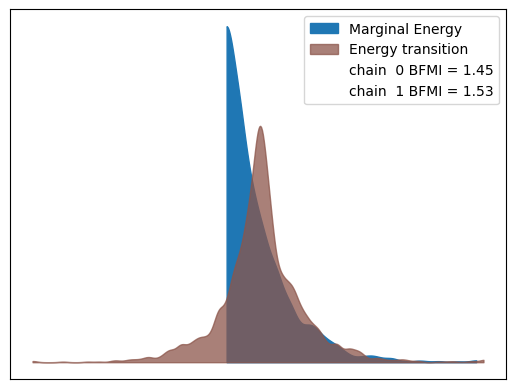

In [22]:
az.plot_energy(idata)

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>]],
      dtype=object)

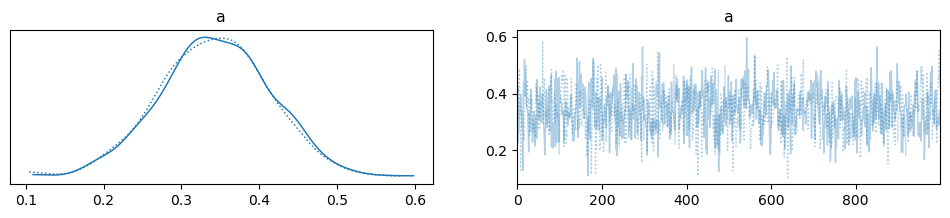

In [23]:
az.plot_trace(idata, var_names=["a"])  # , "lambda_1", "lambda_2", "sigma_f"])

<Axes: title={'center': 'a'}>

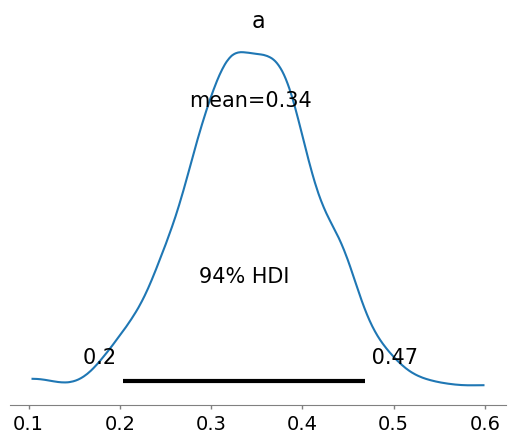

In [24]:
az.plot_posterior(
    idata,
    var_names=["a"],  # , "lambda_1", "lambda_2", "sigma_f"],
)

##### AR(2) for the unobserved factor (estimating just ar1 and ar2 parameters)

In [25]:
class DFM_dummy2(PyMCStateSpace):
    def __init__(self):
        k_states = 2  # state vector has size 2 (for AR(2))
        k_posdef = 1  # Number of shocks remains 1 
        k_endog = 4   # Number of observed variables

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        # Initial state and covariance for 2D state vector
        x0 = self.make_and_register_variable("x0", shape=(2,))
        P0 = self.make_and_register_variable("P0", shape=(2, 2))

        # Loadings
        lambda_1 = self.make_and_register_variable("lambda_1", shape=())
        lambda_2 = self.make_and_register_variable("lambda_2", shape=())
        lambda_3 = self.make_and_register_variable("lambda_3", shape=())
        lambda_4 = self.make_and_register_variable("lambda_4", shape=())

        # Observation noise std dev
        sigma_y1 = self.make_and_register_variable("sigma_y1", shape=())
        sigma_y2 = self.make_and_register_variable("sigma_y2", shape=())
        sigma_y3 = self.make_and_register_variable("sigma_y3", shape=())
        sigma_y4 = self.make_and_register_variable("sigma_y4", shape=())

        # AR(2) coefficients
        ar1 = self.make_and_register_variable("ar1", shape=())
        ar2 = self.make_and_register_variable("ar2", shape=())

        # State noise std dev
        sigma_x = self.make_and_register_variable("sigma_x", shape=())

        # Design matrix: now 4 x 2
        # Observations load only on the first state component (the factor),
        # but you could adjust if desired
        self.ssm["design", :, :] = 0.0
        self.ssm["design", 0, 0] = lambda_1
        self.ssm["design", 1, 0] = lambda_2
        self.ssm["design", 2, 0] = lambda_3
        self.ssm["design", 3, 0] = lambda_4

        # Transition matrix for AR(2):
        #   | a1  a2 |
        #   | 1   0  |
        # This means:
        # x_t     = a1 * x_{t-1} + a2 * x_{t-2} + noise
        # x_{t-1} = x_{t-1}
        self.ssm["transition", :, :] = 0.0
        self.ssm["transition", 0, 0] = ar1
        self.ssm["transition", 0, 1] = ar2
        self.ssm["transition", 1, 0] = 1.0
        self.ssm["transition", 1, 1] = 0.0

        # Selection matrix: size 2 x 1, noise affects only the first component
        self.ssm["selection", :, :] = np.array([[1.0], [0.0]])

        # State covariance Q: noise variance only on the first state
        self.ssm["state_cov", :, :] = 0.0
        self.ssm["state_cov", 0, 0] = sigma_x

        # Observation covariance R
        obs_cov_matrix = pt.diag(pt.stack([sigma_y1, sigma_y2, sigma_y3, sigma_y4]))
        self.ssm["obs_cov", :, :] = obs_cov_matrix

        # Initial state and covariance
        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0

    @property
    def param_names(self):
        return ["x0", "P0", "ar1", "ar2", "sigma_x",
                "lambda_1", "lambda_2", "lambda_3", "lambda_4",
                "sigma_y1", "sigma_y2", "sigma_y3", "sigma_y4"]


In [26]:
dfm = DFM_dummy2()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance for 2D state (AR(2))
    x0 = pm.Deterministic("x0", pt.zeros(2))  # shape (2,)
    P0 = pm.Deterministic("P0", pt.eye(2))    # shape (2, 2)

    # Factor loadings (set to constants)
    lambda_1 = pm.Deterministic("lambda_1", pt.constant(1.0, dtype=float))
    lambda_2 = pm.Deterministic("lambda_2", pt.constant(1.0, dtype=float))
    lambda_3 = pm.Deterministic("lambda_3", pt.constant(1.0, dtype=float))
    lambda_4 = pm.Deterministic("lambda_4", pt.constant(1.0, dtype=float))

    # AR(2) coefficients for factor dynamics
    ar1 = pm.Normal("ar1", sigma=0.5, shape=())  # First lag
    ar2 = pm.Normal("ar2", sigma=0.5, shape=())  # Second lag


    # Latent factor innovation variance (state noise)
    sigma_x = pm.Deterministic("sigma_x", pt.constant(1.0, dtype=float))

    # Observation noise variances
    sigma_y1 = pm.Deterministic("sigma_y1", pt.constant(1.0, dtype=float))
    sigma_y2 = pm.Deterministic("sigma_y2", pt.constant(1.0, dtype=float))
    sigma_y3 = pm.Deterministic("sigma_y3", pt.constant(1.0, dtype=float))
    sigma_y4 = pm.Deterministic("sigma_y4", pt.constant(1.0, dtype=float))

    # Build the symbolic state space graph
    dfm.build_statespace_graph(data=endog_np, mode="JAX")


In [27]:
print_model_ssm(dfm, "draw")

name                __repr__                                          shape     value               
initial_state       initial_state                                     (2,)      [0. 0.]             
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov                                 (2, 2)    [[1. 0.]
                                                                                 [0. 1.]]
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (2,)      [0. 0.]             
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (4,)      [0. 0. 0. 0.]       
----------------------------------------------------------------------------------------------------
transition   

In [28]:
dfm = DFM_dummy2()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance for 2D state (AR(2))
    x0 = pm.Deterministic("x0", pt.zeros(2))  # shape (2,)
    P0 = pm.Deterministic("P0", pt.eye(2))    # shape (2, 2)

    # Factor loadings (set to constants)
    lambda_1 = pm.Deterministic("lambda_1", pt.constant(1.0, dtype=float))
    lambda_2 = pm.Deterministic("lambda_2", pt.constant(1.0, dtype=float))
    lambda_3 = pm.Deterministic("lambda_3", pt.constant(1.0, dtype=float))
    lambda_4 = pm.Deterministic("lambda_4", pt.constant(1.0, dtype=float))

    # AR(2) coefficients for factor dynamics
    ar1 = pm.Normal("ar1", sigma=0.5, shape=())  # First lag
    ar2 = pm.Normal("ar2", sigma=0.5, shape=())  # Second lag


    # Latent factor innovation variance (state noise)
    sigma_x = pm.Deterministic("sigma_x", pt.constant(1.0, dtype=float))

    # Observation noise variances
    sigma_y1 = pm.Deterministic("sigma_y1", pt.constant(1.0, dtype=float))
    sigma_y2 = pm.Deterministic("sigma_y2", pt.constant(1.0, dtype=float))
    sigma_y3 = pm.Deterministic("sigma_y3", pt.constant(1.0, dtype=float))
    sigma_y4 = pm.Deterministic("sigma_y4", pt.constant(1.0, dtype=float))

    # Build the symbolic state space graph
    dfm.build_statespace_graph(data=endog_np, mode="JAX")
    idata = pm.sample(
        draws=1000,
        chains=2,
        nuts_sampler="nutpie",
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,1.07,3
,2000,0,1.08,3


<Axes: >

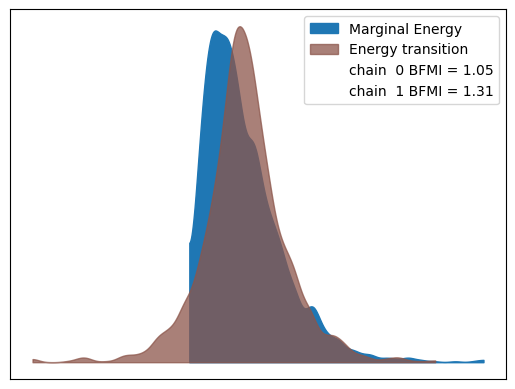

In [29]:
az.plot_energy(idata)

array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar1'}>],
       [<Axes: title={'center': 'ar2'}>, <Axes: title={'center': 'ar2'}>]],
      dtype=object)

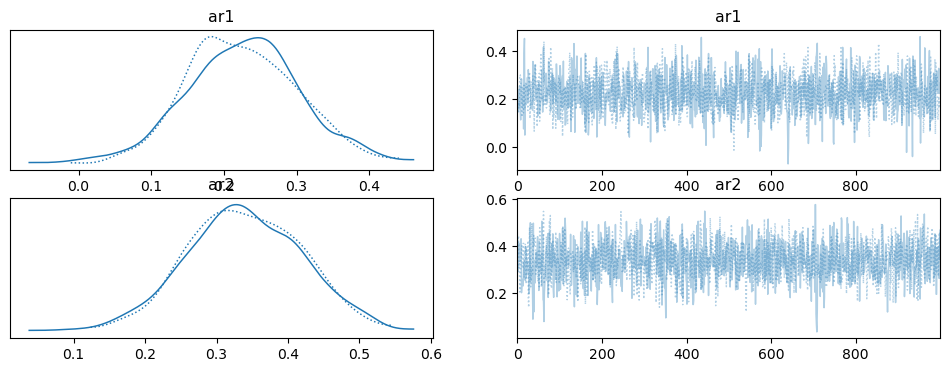

In [30]:
az.plot_trace(idata, var_names=["ar1", "ar2"])  # , "lambda_1", "lambda_2", "sigma_f"])

array([<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar2'}>],
      dtype=object)

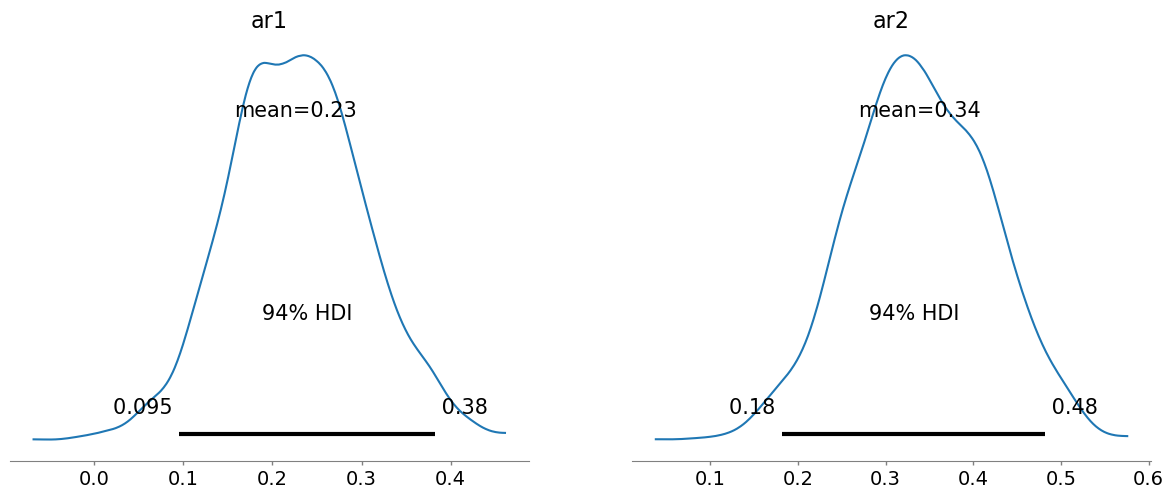

In [31]:
az.plot_posterior(
    idata,
    var_names=["ar1", "ar2"],  # , "lambda_1", "lambda_2", "sigma_f"],
)

##### AR(2) for the unobserved factor

In [32]:
class DFM_dummy3(PyMCStateSpace):
    def __init__(self):
        k_states = 2  # state vector has size 2 (for AR(2))
        k_posdef = 1  # Number of shocks remains 1 
        k_endog = 4   # Number of observed variables

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        # Initial state and covariance for 2D state vector
        x0 = self.make_and_register_variable("x0", shape=(2,))
        P0 = self.make_and_register_variable("P0", shape=(2, 2))

        # Loadings
        lambda_1 = self.make_and_register_variable("lambda_1", shape=())
        lambda_2 = self.make_and_register_variable("lambda_2", shape=())
        lambda_3 = self.make_and_register_variable("lambda_3", shape=())
        lambda_4 = self.make_and_register_variable("lambda_4", shape=())


        # AR(2) coefficients
        ar1 = self.make_and_register_variable("ar1", shape=())
        ar2 = self.make_and_register_variable("ar2", shape=())

        # State noise std dev
        sigma_x = self.make_and_register_variable("sigma_x", shape=())

        # Design matrix: now 4 x 2
        # Observations load only on the first state component (the factor),
        # but you could adjust if desired
        self.ssm["design", :, :] = 0.0
        self.ssm["design", 0, 0] = lambda_1
        self.ssm["design", 1, 0] = lambda_2
        self.ssm["design", 2, 0] = lambda_3
        self.ssm["design", 3, 0] = lambda_4

        # Transition matrix for AR(2):
        #   | a1  a2 |
        #   | 1   0  |
        # This means:
        # x_t     = a1 * x_{t-1} + a2 * x_{t-2} + noise
        # x_{t-1} = x_{t-1}
        self.ssm["transition", :, :] = 0.0
        self.ssm["transition", 0, 0] = ar1
        self.ssm["transition", 0, 1] = ar2
        self.ssm["transition", 1, 0] = 1.0
        self.ssm["transition", 1, 1] = 0.0

        # Selection matrix: size 2 x 1, noise affects only the first component
        self.ssm["selection", :, :] = np.array([[1.0], [0.0]])

        # State covariance Q: noise variance only on the first state
        self.ssm["state_cov", :, :] = 0.0
        self.ssm["state_cov", 0, 0] = sigma_x

        # Observation covariance R
        obs_cov_matrix = pt.diag(np.ones(4, dtype=float))
        self.ssm["obs_cov", :, :] = obs_cov_matrix

        # Initial state and covariance
        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0

    @property
    def param_names(self):
        return ["x0", "P0", "ar1", "ar2", "sigma_x",
                "lambda_1", "lambda_2", "lambda_3", "lambda_4"]


In [33]:
dfm = DFM_dummy3()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance for 2D state (AR(2))
    x0 = pm.Deterministic("x0", pt.zeros(2))  # shape (2,)
    P0 = pm.Deterministic("P0", pt.eye(2))    # shape (2, 2)

    # Factor loadings (set to constants)
    lambda_1 = pm.Normal("lambda_1", sigma=1.0, shape=())
    lambda_2 = pm.Normal("lambda_2", sigma=1.0, shape=())
    lambda_3 = pm.Normal("lambda_3", sigma=1.0, shape=())
    lambda_4 = pm.Normal("lambda_4", sigma=1.0, shape=())


    # AR(2) coefficients for factor dynamics
    ar1 = pm.Normal("ar1", sigma=0.5, shape=())  # First lag
    ar2 = pm.Normal("ar2", sigma=0.5, shape=())  # Second lag


    # Latent factor innovation variance (state noise)
    sigma_x = pm.Deterministic("sigma_x", pt.constant(1.0, dtype=float))


    # Build the symbolic state space graph
    dfm.build_statespace_graph(data=endog_np, mode="JAX")


In [34]:
print_model_ssm(dfm, "draw")

name                __repr__                                          shape     value               
initial_state       initial_state                                     (2,)      [0. 0.]             
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov                                 (2, 2)    [[1. 0.]
                                                                                 [0. 1.]]
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (2,)      [0. 0.]             
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (4,)      [0. 0. 0. 0.]       
----------------------------------------------------------------------------------------------------
transition   

In [36]:
dfm = DFM_dummy3()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance for 2D state (AR(2))
    x0 = pm.Deterministic("x0", pt.zeros(2))  # shape (2,)
    P0 = pm.Deterministic("P0", pt.eye(2))    # shape (2, 2)

    # Factor loadings (set to constants)
    lambda_1 = pm.Normal("lambda_1", sigma=1.0, shape=())
    lambda_2 = pm.Normal("lambda_2", sigma=1.0, shape=())
    lambda_3 = pm.Normal("lambda_3", sigma=1.0, shape=())
    lambda_4 = pm.Normal("lambda_4", sigma=1.0, shape=())

    # AR(2) coefficients for factor dynamics
    ar1 = pm.Normal("ar1", sigma=0.5, shape=())  # First lag
    ar2 = pm.Normal("ar2", sigma=0.5, shape=())  # Second lag


    # Latent factor innovation variance (state noise)
    sigma_x = pm.Deterministic("sigma_x", pt.constant(1.0, dtype=float))


    # Build the symbolic state space graph
    dfm.build_statespace_graph(data=endog_np, mode="JAX")
    idata = pm.sample(
        draws=1000,
        chains=2,
        nuts_sampler="nutpie",
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.34,7
,2000,0,0.33,7


<Axes: >

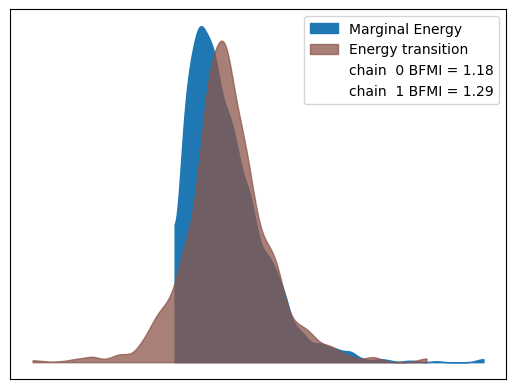

In [ ]:
az.plot_energy(idata)

array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar1'}>],
       [<Axes: title={'center': 'ar2'}>, <Axes: title={'center': 'ar2'}>],
       [<Axes: title={'center': 'lambda_1'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_2'}>],
       [<Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_3'}>],
       [<Axes: title={'center': 'lambda_4'}>,
        <Axes: title={'center': 'lambda_4'}>]], dtype=object)

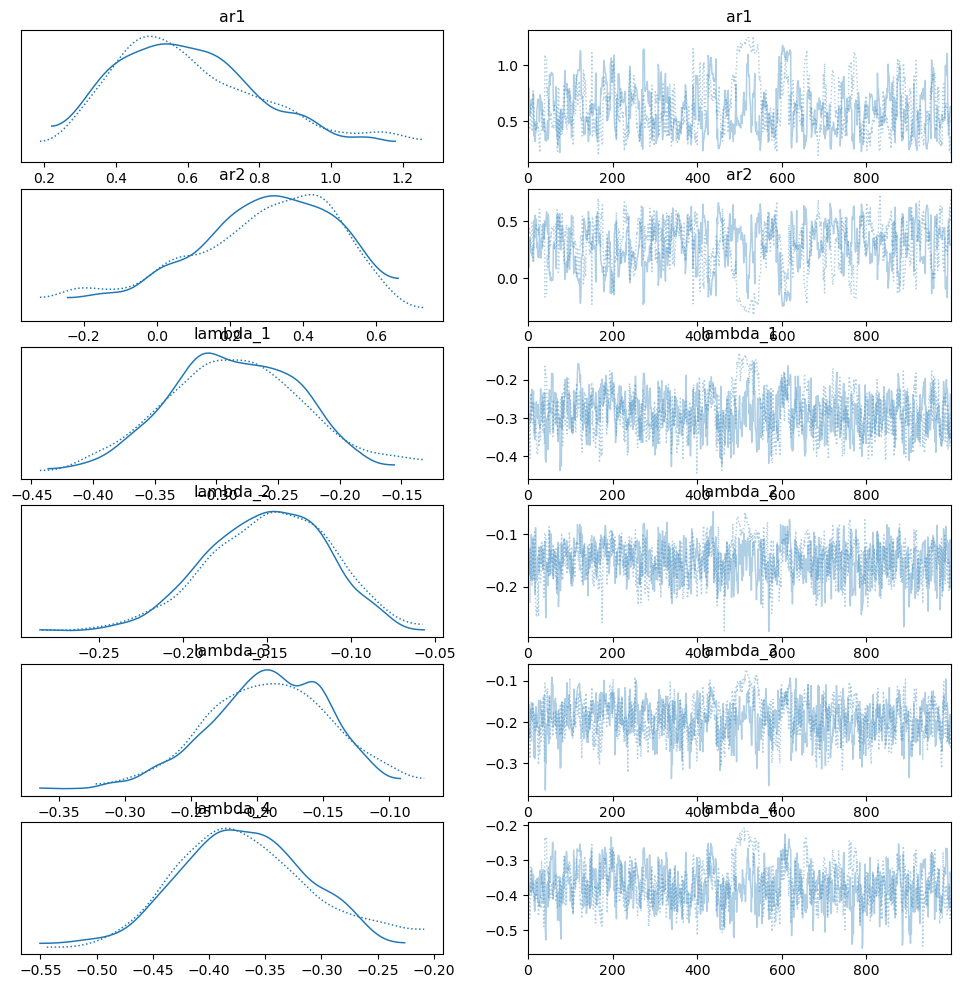

In [ ]:
az.plot_trace(idata, var_names=["ar1", "ar2", "lambda_1", "lambda_2", "lambda_3", "lambda_4"])

array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar2'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_4'}>]], dtype=object)

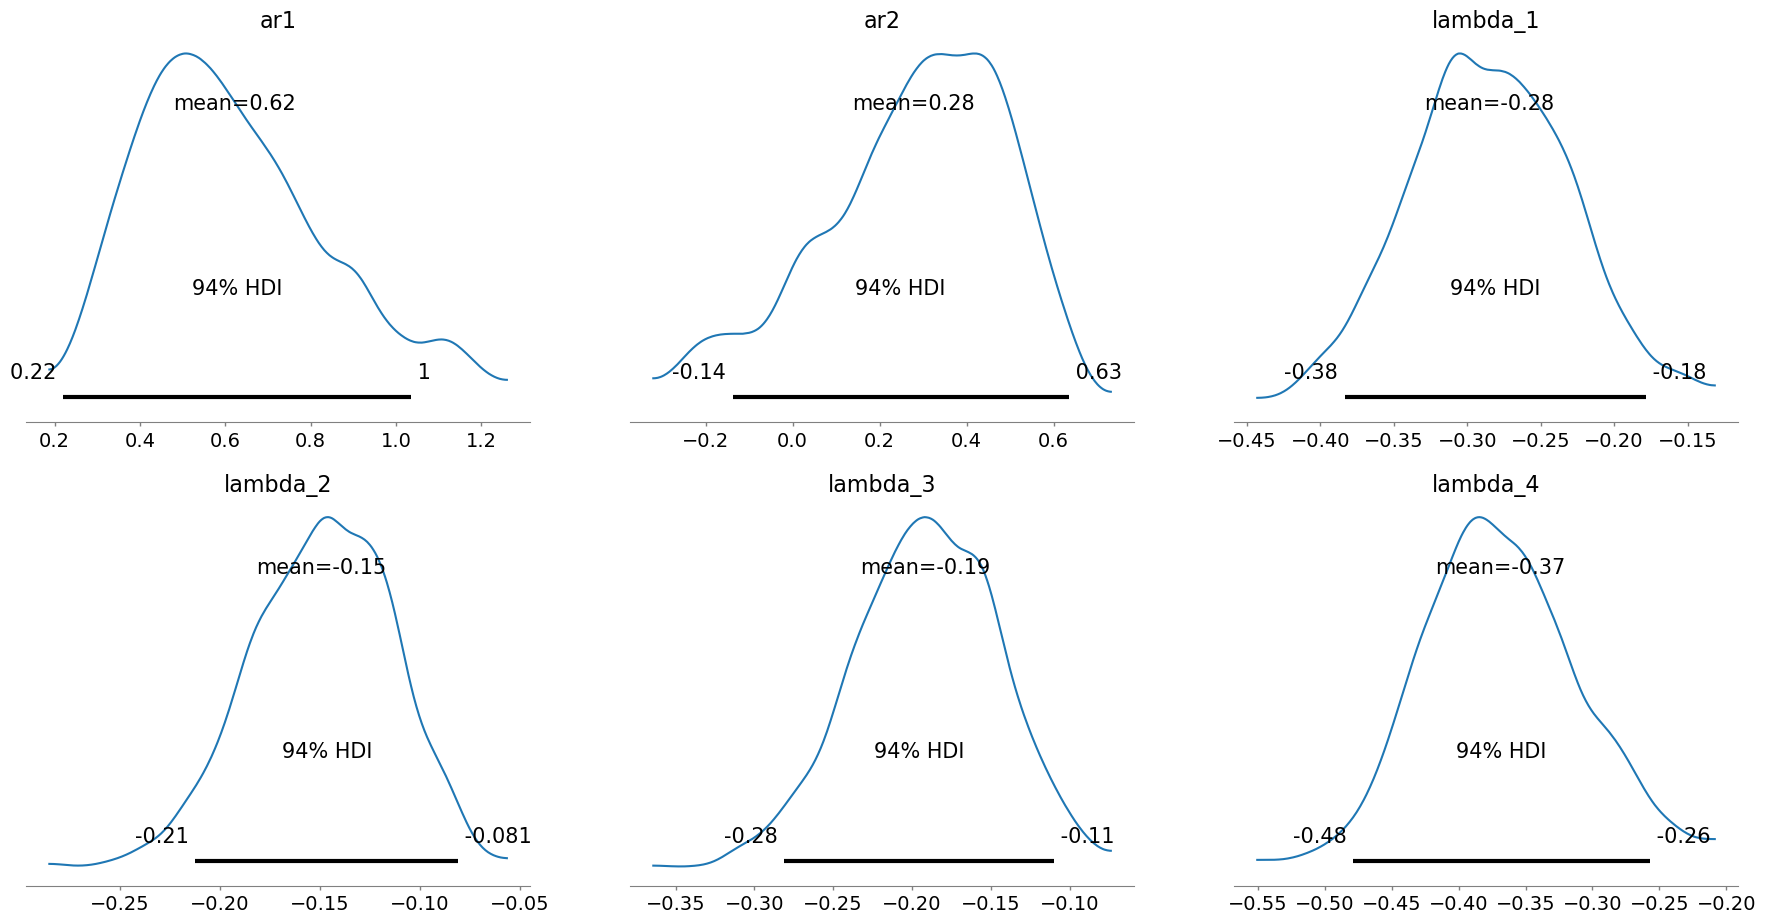

In [ ]:
az.plot_posterior(
    idata,
    var_names=["ar1", "ar2", "lambda_1", "lambda_2", "lambda_3", "lambda_4"],  
)

##### AR(2) for the unobserved factor and for the error

In [37]:
class DFM_dummy4(PyMCStateSpace):
    def __init__(self):
        k_states = 10  # 2 for factor + 2*4 for error terms
        k_posdef = 5   # 1 for factor shock + 4 for individual AR error shocks
        k_endog = 4

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        x0 = self.make_and_register_variable("x0", shape=(10,))
        P0 = self.make_and_register_variable("P0", shape=(10, 10))

        # Loadings λ_i
        lambdas = [self.make_and_register_variable(f"lambda_{i+1}", shape=()) for i in range(4)]

        # AR(2) coeffs for the factor
        ar1 = self.make_and_register_variable("ar1", shape=())
        ar2 = self.make_and_register_variable("ar2", shape=())
        sigma_f = self.make_and_register_variable("sigma_f", shape=())

        # AR(2) coeffs and std dev for each u_{i,t}
        c = []
        sigmas = []
        for i in range(4):
            c1 = self.make_and_register_variable(f"c{i+1}_1", shape=())
            c2 = self.make_and_register_variable(f"c{i+1}_2", shape=())
            sigma_u = self.make_and_register_variable(f"sigma_u{i+1}", shape=())
            c.append((c1, c2))
            sigmas.append(sigma_u)

        # Design matrix
        self.ssm["design", :, :] = 0.0
        for i in range(4):
            self.ssm["design", i, 0] = lambdas[i]   # load on factor
            self.ssm["design", i, 2*i+2] = 1.0       # load on u_{i,t}

        # Transition matrix (AR(2) for factor and for each u_i,t)
        self.ssm["transition", :, :] = 0.0
        self.ssm["transition", 0, 0] = ar1
        self.ssm["transition", 0, 1] = ar2
        self.ssm["transition", 1, 0] = 1.0

        for i in range(4):
            pos = 2*i + 2
            c1, c2 = c[i]
            self.ssm["transition", pos, pos] = c1
            self.ssm["transition", pos, pos+1] = c2
            self.ssm["transition", pos+1, pos] = 1.0

        # Selection matrix: noise affects only first state of each AR(2)
        self.ssm["selection", :, :] = 0.0
        self.ssm["selection", 0, 0] = 1.0  # factor noise
        for i in range(4):
            self.ssm["selection", 2*i+2, i+1] = 1.0  # u_i,t noise

        # State covariance Q
        self.ssm["state_cov", :, :] = 0.0
        self.ssm["state_cov", 0, 0] = sigma_f
        for i in range(4):
            self.ssm["state_cov", i+1, i+1] = sigmas[i]

        # obs_cov is now just numerical precision
        self.ssm["obs_cov", :, :] = pt.diag(pt.constant(np.zeros(4)))

        # Initial conditions
        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0

    @property
    def param_names(self):
        names = ["x0", "P0", "ar1", "ar2", "sigma_f"]
        for i in range(4):
            names.extend([f"lambda_{i+1}", f"c{i+1}_1", f"c{i+1}_2", f"sigma_u{i+1}"])
        return names


In [42]:
dfm = DFM_dummy4()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance for full 10D state vector
    x0 = pm.Deterministic("x0", pt.zeros(10))
    P0 = pm.Deterministic("P0", pt.eye(10))

    # Factor loadings
    lambda_1 = pm.Normal("lambda_1", sigma=1.0)
    lambda_2 = pm.Normal("lambda_2", sigma=1.0)
    lambda_3 = pm.Normal("lambda_3", sigma=1.0)
    lambda_4 = pm.Normal("lambda_4", sigma=1.0)

    # AR(2) coefficients for factor f_t
    ar1 = pm.Normal("ar1", sigma=0.5)
    ar2 = pm.Normal("ar2", sigma=0.5)

    sigma_f = pm.Deterministic("sigma_f", pt.constant(1.0, dtype=float))

    # AR(2) coefficients and noise stds for the 4 error terms u_{i,t}
    for i in range(1, 5):  # i = 1 to 4
        pm.Normal(f"c{i}_1", sigma=0.5)
        pm.Normal(f"c{i}_2", sigma=0.5)
        pm.HalfNormal(f"sigma_u{i}", sigma=1.0)

    # Build symbolic graph
    dfm.build_statespace_graph(data=endog_np, mode="JAX")


In [43]:
print_model_ssm(dfm, "draw")

name                __repr__                                          shape     value               
initial_state       initial_state                                     (10,)     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov                                 (10, 10)  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
        

In [44]:
dfm = DFM_dummy4()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance for full 10D state vector
    x0 = pm.Deterministic("x0", pt.zeros(10))
    P0 = pm.Deterministic("P0", pt.eye(10))

    # Factor loadings
    lambda_1 = pm.Normal("lambda_1", sigma=1.0)
    lambda_2 = pm.Normal("lambda_2", sigma=1.0)
    lambda_3 = pm.Normal("lambda_3", sigma=1.0)
    lambda_4 = pm.Normal("lambda_4", sigma=1.0)

    # AR(2) coefficients for factor f_t
    ar1 = pm.Normal("ar1", sigma=0.5)
    ar2 = pm.Normal("ar2", sigma=0.5)

    sigma_f = pm.Deterministic("sigma_f", pt.constant(1.0, dtype=float))

    # AR(2) coefficients and noise stds for the 4 error terms u_{i,t}
    for i in range(1, 5):  # i = 1 to 4
        pm.Normal(f"c{i}_1", sigma=0.5)
        pm.Normal(f"c{i}_2", sigma=0.5)
        pm.HalfNormal(f"sigma_u{i}", sigma=1.0)

    # Build symbolic graph
    dfm.build_statespace_graph(data=endog_np, mode="JAX")
    idata = pm.sample(
        draws=1000,
        chains=2,
        nuts_sampler="nutpie",
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.62,7
,2000,0,0.61,7


<Axes: >

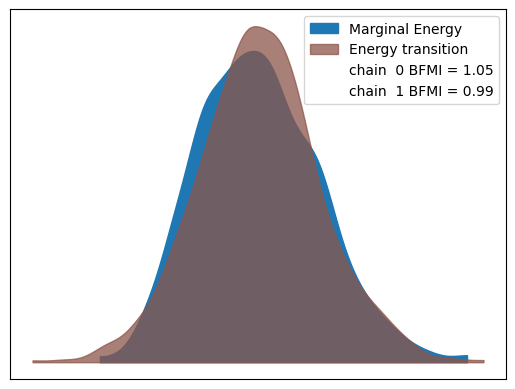

In [45]:
az.plot_energy(idata)

array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar1'}>],
       [<Axes: title={'center': 'ar2'}>, <Axes: title={'center': 'ar2'}>],
       [<Axes: title={'center': 'lambda_1'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_2'}>],
       [<Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_3'}>],
       [<Axes: title={'center': 'lambda_4'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_1'}>],
       [<Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'c1_2'}>],
       [<Axes: title={'center': 'sigma_u1'}>,
        <Axes: title={'center': 'sigma_u1'}>],
       [<Axes: title={'center': 'c2_1'}>,
        <Axes: title={'center': 'c2_1'}>],
       [<Axes: title={'center': 'c2_2'}>,
        <Axes: title={'center': 'c2_2'}>],
       [<Axes: title={'center': 'sigma_u2'}>,

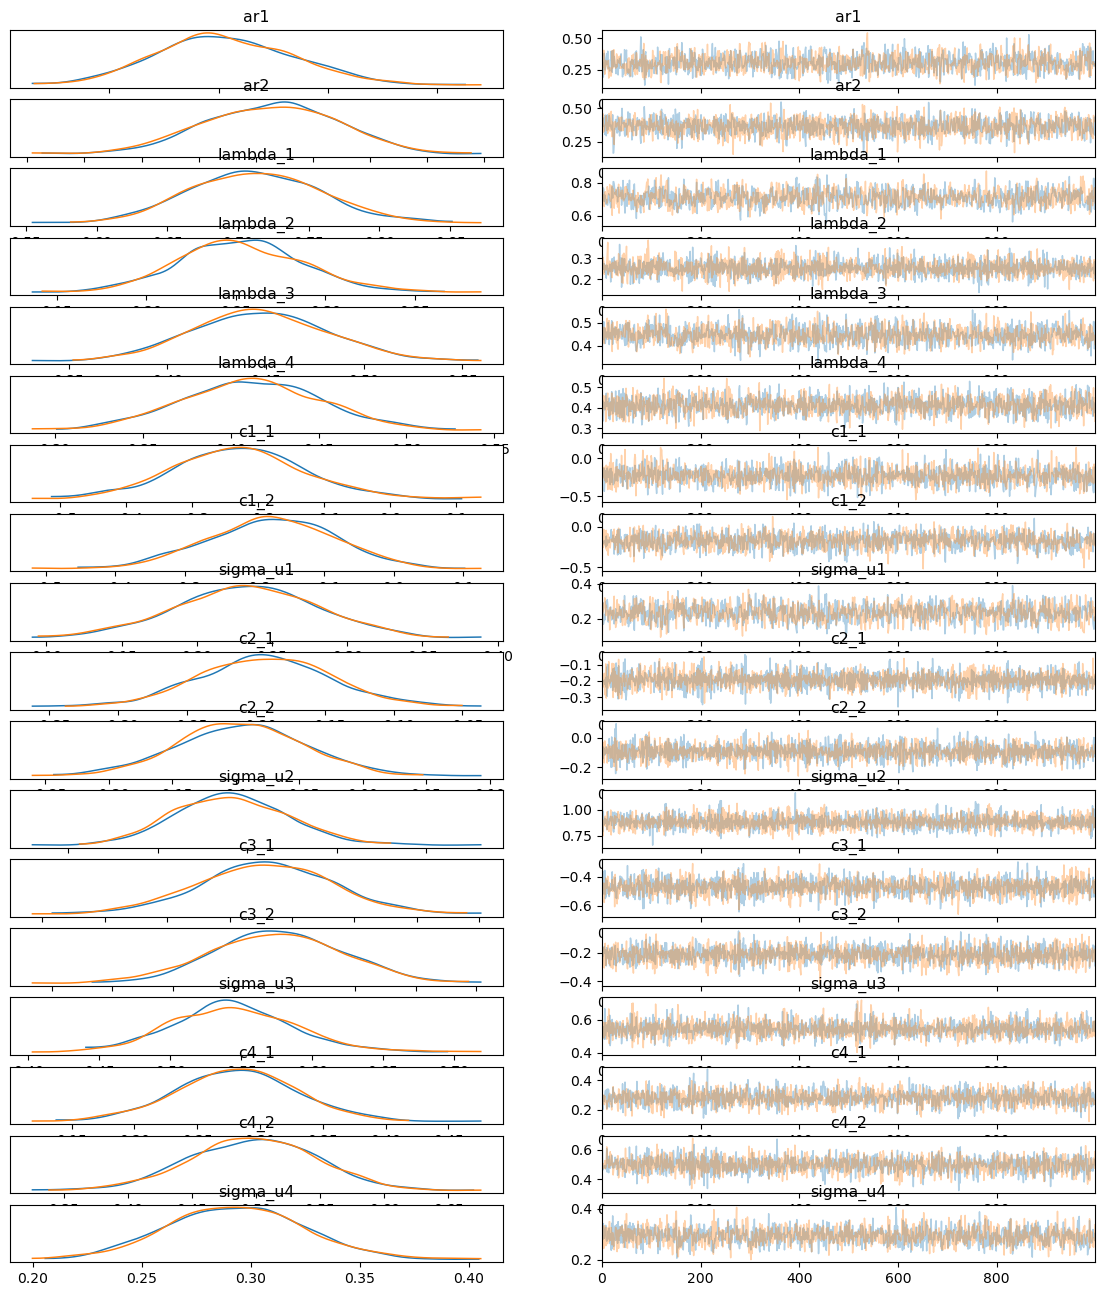

In [46]:
az.plot_trace(
    idata,
    var_names=[
        "ar1", "ar2",
        "lambda_1", "lambda_2", "lambda_3", "lambda_4",
        "c1_1", "c1_2", "sigma_u1",
        "c2_1", "c2_2", "sigma_u2",
        "c3_1", "c3_2", "sigma_u3",
        "c4_1", "c4_2", "sigma_u4"
    ],
    figsize=(14, 16),
    compact=False
)

array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar2'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'sigma_u1'}>],
       [<Axes: title={'center': 'c2_1'}>,
        <Axes: title={'center': 'c2_2'}>,
        <Axes: title={'center': 'sigma_u2'}>],
       [<Axes: title={'center': 'c3_1'}>,
        <Axes: title={'center': 'c3_2'}>,
        <Axes: title={'center': 'sigma_u3'}>],
       [<Axes: title={'center': 'c4_1'}>,
        <Axes: title={'center': 'c4_2'}>,
        <Axes: title={'center': 'sigma_u4'}>]], dtype=object)

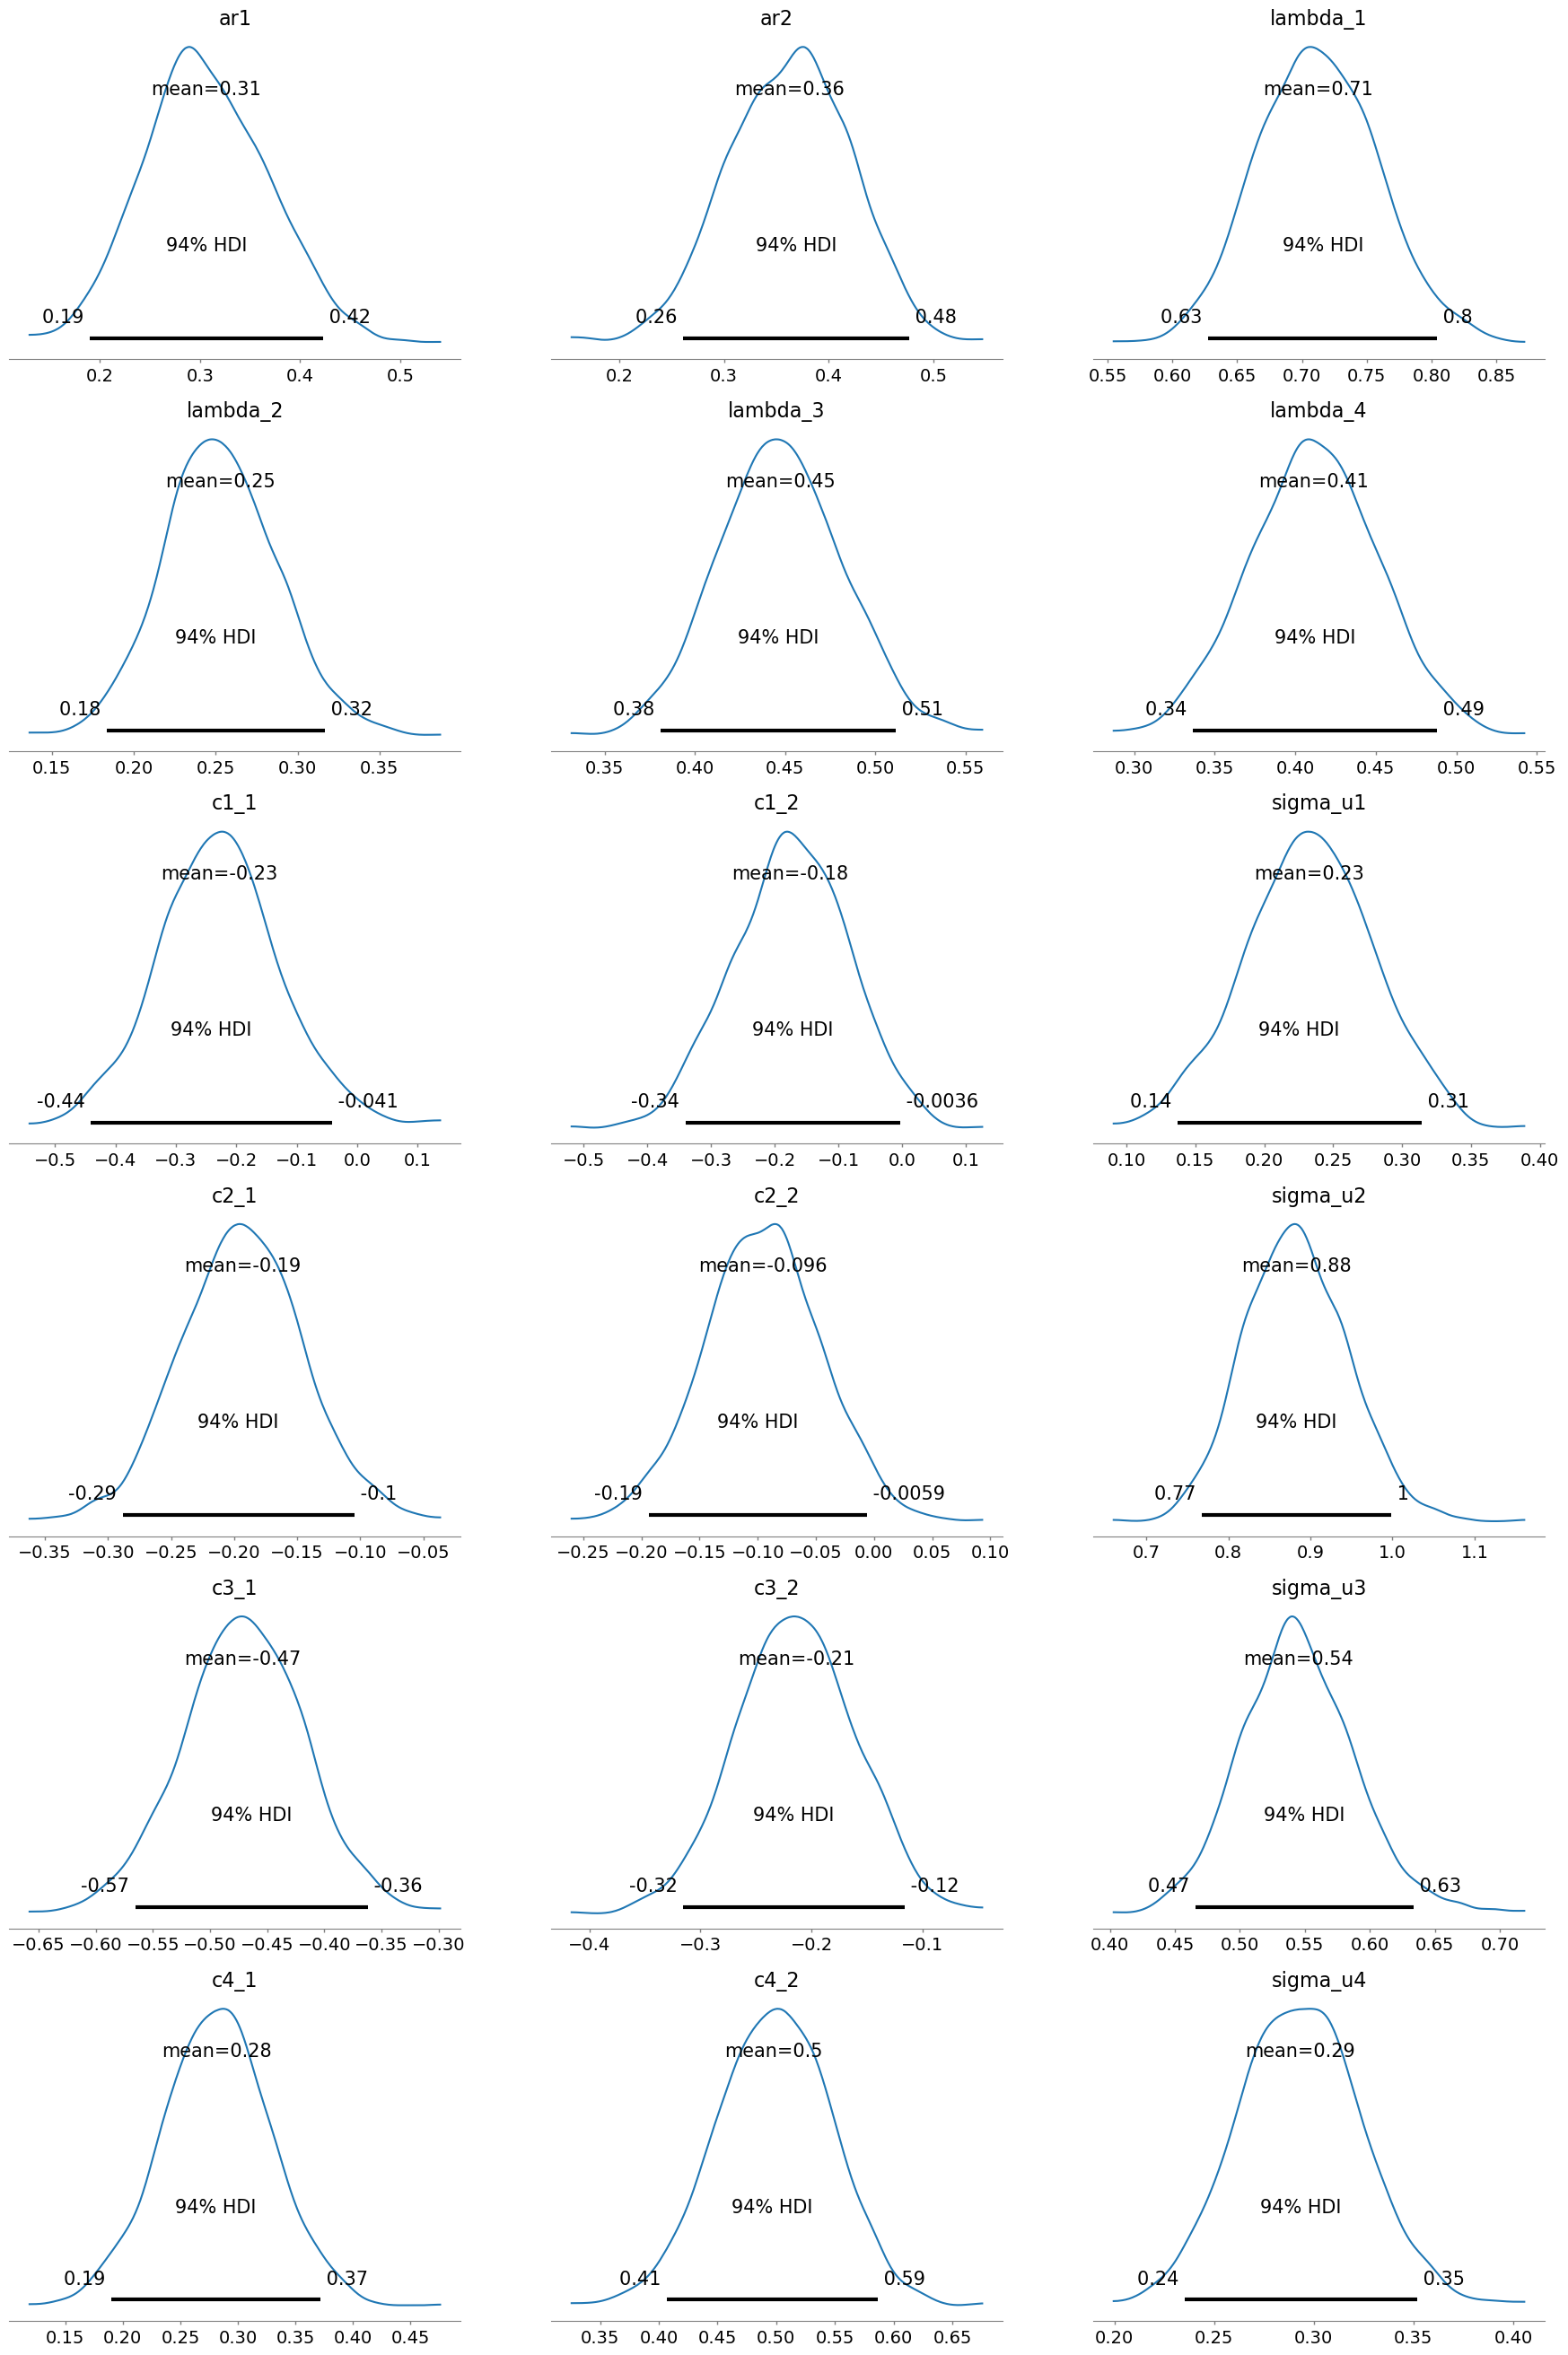

In [47]:
az.plot_posterior(
    idata,
    var_names=[ "ar1", "ar2",
        "lambda_1", "lambda_2", "lambda_3", "lambda_4",
        "c1_1", "c1_2", "sigma_u1",
        "c2_1", "c2_2", "sigma_u2",
        "c3_1", "c3_2", "sigma_u3",
        "c4_1", "c4_2", "sigma_u4"],  
)